[![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# 多模式

## 回顾

我们介绍了状态模式和 reducers。

通常，所有图节点都通过单个模式进行通信。

此外，这个单个模式包含了图的输入和输出的键/通道。

## 目标

但是，有些情况下我们可能希望对此有更多的控制：

* 内部节点可能传递图中的输入/输出中*非必须的*信息。

* 我们可能还希望为图使用不同的输入/输出模式。例如：输出可能仅包含一个单独的相关的输出键。

我们将讨论一些通过多模式自定义图的方法。

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## 私有状态

首先，让我们讨论一下在节点之间传递[私有状态]的情况(https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/)。

这对于作为图中间工作逻辑一部分所需的内容很有用，但是与整个图的输入或输出无关。

我们将定义一个 `OverallState` 和一个 `PrivateState`.

`node_2` 使用 `PrivateState` 作为输入，但是将输出写入到 `OverallState`.

In [42]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
# from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
# import base64

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
print(graph.get_graph().draw_mermaid())
# image_url = (
#     f"https://mermaid.ink/img/{base64.b64encode(graph.get_graph().draw_mermaid().encode("utf8")).decode(
#     "ascii"
# )}"
#     "?type=png&bgColor=white"
# )
# print(image_url)
# display(Image(graph.get_graph().draw_mermaid_png()))
    

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	node_1(node_1)
	node_2(node_2)
	__end__([<p>__end__</p>]):::last
	__start__ --> node_1;
	node_1 --> node_2;
	node_2 --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [31]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` 仅仅被包含在 `PrivateState` 中。

`node_2` 使用 `PrivateState` 作为输入，但是输出到 `OverallState` 。

因此，我们可以看到 `baz` 被排除在图的输出之外，因为他不在 `OverallState` 中。

## 输入 / 输出 模式

默认情况下，`StateGraph` 接受单个模式，并且所有节点都应该与通过该模式进行通信。

然而，也可以[为图定义明确的输入和输出模式](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

通常，在这些情况下，我们会定义一个包含*所有*与图操作有关的键的“内部”模式。

但是，我们使用明确的 `输入` 和 `输出` 模式来约束输入和输出。

首先，让我们只用一个单独的模式来运行这个图。

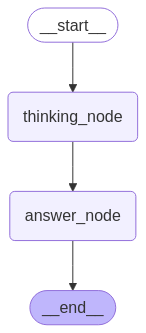

In [43]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

注意：执行的输出包含所有在 `OverallState` 中的键。

In [44]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

现在，让我们使用明确的 `输入` 和 `输出` 模式来处理我们的图。

这里，`输入` / `输出` 模式对图的输入和输出中允许的键进行*过滤* 。

另外，我们可以使用一个类型提示 `state: InputState` 来明确指定我们每个节点的输入模式。

当图使用多模式时这非常重要。

我们使用下边的类型提示，例如：显示 `answer_node` 的输出将被过滤到 `OutputState`. 

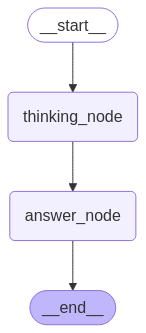

{'answer': 'bye Lance'}

In [45]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

我们可以看到 `输出` 模式将输出限制为仅包含 `answer` 键。